## DMiA 2018 (spring) #Спорт

### Домашнее задание 1  
Выполнила: Хужина Вария  
<span style="color:blue"><b>23 место (0.92532 Private Leaderboard)</b>

## Задание
В этом задании вам нужно построить классификатор, определяющий, является ли слово фамилией. Для оценки качества используется площадь под ROC-кривой (AUC), так как классы сильно несбалансированны.

## Идея
1. Векторайзер (Count, Tfidf) с использованием n-gramm (представление слов в виде мешка букв и сочетаний букв)
2. Использование предобученной модели pymorphy2
3. Отбор признаков 
4. Предсказание с помощью логистической регрессии

##  Загрузка данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
df.head()

,Word,Label
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0


In [4]:
df_test.head()

,Word
0,Аалто
1,ААР
2,Аара
3,Ааре
4,Аарон


In [5]:
df['Label'].value_counts()

0    90770
1    10638
Name: Label, dtype: int64

Классы несбалансированы, если предсказывать всем нулевой класс, то accuracy (доля правильных ответов) будет:

In [6]:
1-df['Label'].value_counts()[1]/df['Label'].value_counts()[0]

0.8828026881128126

In [7]:
df.shape

(101408, 2)

## Визулизация данных

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Посмотрим на длину слов

In [9]:
surname_length = df[df['Label'] == 1]['Word'].apply(lambda word: len(word))
word_length = df[df['Label'] == 0]['Word'].apply(lambda word: len(word))

Mean length for surname: 7.15
Mean length for word: 8.60


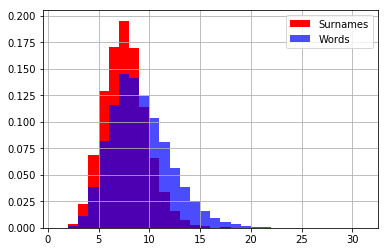

In [10]:
plt.grid(True)
plt.hist(surname_length, bins=max(surname_length)-min(surname_length), density=True, label='Surnames', color='red');
plt.hist(word_length, bins=max(word_length)-min(word_length), alpha=0.7,  density=True, label='Words', color='blue');
plt.legend(loc='upper right');

print('Mean length for surname: %.2f'%np.mean(surname_length))
print('Mean length for word: %.2f'%np.mean(word_length))

В среднем слова длинее фамилий

## Предобработка данных и выбор лучших параметров с помощью конвеера Pipeline

Разбиения набора данных во время перекрестной проверки должны быть выполнены перед предварительной обработкой данных. Любой процесс, извлекающий знания из данных, должен осуществляться на обучающей части набора данных, и поэтому его следует разместить внутри цикла перекрестной проверки.

In [11]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from pymorphy2 import MorphAnalyzer

In [13]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [14]:
class MorphFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        morph = MorphAnalyzer()
        for i, word in enumerate(X):
            tags = morph.parse(word)[0].tag
            features.append({'Single': int('sing' in tags),
                             'Surname': int(('Surn' in tags) or ('Name' in tags))})   
        return features

## Конвеер 
Этапы:
1. Создание новых признаков с помощью pymorphy2
   - выбор признака 'Word'
   - генерация новых признаков
2. Обработка слов с помощью CountVectorizer  
   - выбор признака 'Word'
   - преобразование CountVectorizer()
   - отбор признаков
3. Обработка слов с помощью TfidfVectorizer
   - выбор признака 'Word'
   - преобразование TfidfVectorizer()
   - отбор признаков
4. Обучение данных с помощью линейной модели LogisticRegression

### FeatureUnion

In [15]:
transformer_list = [('pymorphy',
                     Pipeline( [
                         ('selector', FeatureSelector('Word')),
                         ('new_features', MorphFeatures()),
                         ('vect', DictVectorizer()) ] )
                    ),
                   ('bagofchars',
                    Pipeline([
                        ('selector', FeatureSelector('Word')), 
                        ('vectorizer', CountVectorizer(lowercase=False, analyzer='char_wb')),
                        ('feature_selector', SelectFromModel(LogisticRegression(penalty='l1', class_weight='balanced'))) ] )
                   ),
                   ('tfidf',
                   Pipeline([
                       ('selector', FeatureSelector('Word')),
                       ('vectorizer', TfidfVectorizer(analyzer='char', lowercase=False)),
                       ('feature_selector', SelectFromModel(LogisticRegression(penalty='l1', class_weight='balanced')))] )
                   )
                   ]

union = FeatureUnion(transformer_list=transformer_list, transformer_weights={'pymorphy': 1, 'bagofchars': 1, 'tfidf':1})

In [16]:
logit = LogisticRegression(class_weight='balanced')

### Pipeline

In [17]:
pipe = Pipeline([('union', union), 
                 ('logit', logit)
                ])

### GridSearchCV
(здесь дана окончательная версия параметров)

In [18]:
param_grid = {'union__bagofchars__vectorizer__ngram_range': [(1, 5)],
              'union__bagofchars__vectorizer__max_features': [101408],
              'union__tfidf__vectorizer__ngram_range': [(2, 5)], 
              'union__tfidf__vectorizer__max_features': [101408],
               'logit__C': [0.2]}

In [19]:
%%time
cv = StratifiedKFold(4, shuffle=True, random_state=21)

grid_seacher = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_seacher.fit(df.drop(columns='Label'), df['Label'])

CPU times: user 1min 4s, sys: 616 ms, total: 1min 4s
Wall time: 8min 27s


In [20]:
grid_seacher.best_score_

0.9192832696468688

## Предсказание

Преобразовываем отложенные данные и предсказываем вероятности

In [21]:
prob_final = grid_seacher.best_estimator_.predict_proba(df_test)

In [22]:
submission = pd.DataFrame({'Id': range(0, len(df_test)), 'Prediction':prob_final[:, 1]})

In [23]:
submission.to_csv('my_submission.csv', index=False)